$\newcommand{\ket}[1]{\left|#1\right>}$

$\newcommand{\bra}[1]{\left<#1\right|}$

$\newcommand{\braket}[2]{\left<#1 | #2\right>}$

# From QUBO Problems to Ising Hamiltonian

QUBO stands for Quadratic Unconstrained Binary Optimization and are a class of problems that may get important benefits from quantum computation.

Let's see how they are defined and how to wirte them in a form that is particularly suitable for quantum computers. Everything through an example.

## A QUBO problem example

QUBO problems have this particular name since they are:
- quadratic, in the sense that the solution appear at second order;
- binary, since each term of the solution can get value 0 or 1.

Let's consider the following example: we want to optimize the performance of a team of three individuals, deciding which of them have to stay in the same office in order to get the best possible results.
Our main characters are:
- a professor;
- his student;
- the professor's cat.

The presence fo each of them gives a contribution to the final result, which we can quantify with a number. <br>
So, the professor is very expert at his job and his presence add 10 points to the final result. His student is smart, but not as expert as him, so his presence in the office gives just 5 points. As we can imagine, the cat contribute with 0 points.

But we also observe that when the professor and the student are in the office together, they talk about work, enhancing the score by 4 points. We also see that the professor is very happy the see his cat in the office, so that its contribution increses by 2 points when they are together. Unluckily, the student is allergic to cats, so that the presence of the cat and the student together at the same time reduces the efficiency of the team (-12 points).

We can summarize the relationship among our characters through the following graph.

<img src='DAG.png'>

Assuming that our solution x has the form:

$$ x = \{ Professor, Student, Cat\}$$

we can write the function associated to the score as:

$$ F(x) = 10 x_1 + 5 x_2 + 0 x_3 + 4 x_1 x_2 + 2 x_1 x_3 - 12 x_2 x_3$$

where:
- $ x_1 \in \{ 0,1 \} $
- $ x_2 \in \{ 0,1 \} $
- $ x_3 \in \{ 0,1 \} $

If we now want to put the problem in a more formal shape, we can introduce the formalism of QUBO problems:

$$ F(x) = \sum_{i,j = 1}^{n} x_i Q_{ij} x_j $$

$$ x \in \{ 0,1 \}^n $$

where n indicates the number of nodes of the graph (in our case, n = 3) and when $x_i = 0$, the corresponding node is *turned off*, while if $x_i = 1$ it is *turned on*. In this example, a node is turned on/off if the corresponding character is present/absent.

$Q$ is the matrix that contains the information about the nodes and arcs of the graph and for our problem, it can be written as:

$$ Q = 
\begin{bmatrix}
    10 &  2 &  1   \\
     2 &  5 & -6 \\
     1 & -6 &  0
\end{bmatrix}$$

Here, the off-diagonal terms are half the original value, since otherwise we would be counted them twice. This is due to the fact that we consider both the term (i,j) and the term (j,i) of the matrix when we do the actual calculations, as can be easily verified.

Since this is a small and easy problem, we can find the optimal solution by calculating all the possible global scores and keep the configuration that gives the highest value.

case = [0, 0, 0] score = 0
case = [1, 0, 0] score = 10
case = [0, 1, 0] score = 5
case = [1, 1, 0] score = 19
case = [0, 0, 1] score = 0
case = [1, 0, 1] score = 12
case = [0, 1, 1] score = -7
case = [1, 1, 1] score = 9

Best solution = [1, 1, 0] cost = 19


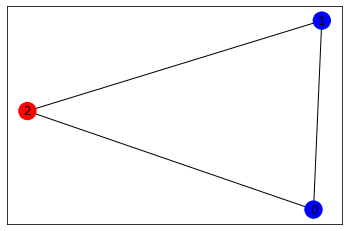

In [1]:
import numpy as np
import networkx as nx

# number of characters
n = 3

# Q matrix definition
Q = np.array([[10,  2,  1],
              [ 2,  5, -6],
              [ 1, -6,  0]])

best_cost_brute = 0

# computing all possible combinations
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + Q[i,j]*x[i]*x[j]
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' score = ' + str(cost))

# Showing results    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
G = nx.gnm_random_graph(n = n,m = n, seed = 1)
nx.draw_networkx(G, node_color=colors)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))  

So we see that the cat should be excluded from the office :(

## The Ising Formalism

The former approach to solve our QUBO problem fits examples with small n. 
In general, due to the huge computational resources needed to find the best configuration, we would like to find a more efficient algorithm.
Additionally, the formalism used so far is well designed if we work with a classical computer, where bits can get values 0 or 1.

If we want to exploit the potential of quantum computing, we have to re-write the problem such that it can be efficiently encoded in terms of qbits, which can be in any state like:

$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$

where $\alpha$ and $\beta$ are complex coefficients that satisfy the relation:

$ |\alpha|^2 + |\beta|^2 = 1 $

We state that the Ising formalism allows to get the same solution as the QUBO formalism, but fullfulling our goal of having a qbit-friendly way of writing our problem.

To get our problem written in the Ising formalism, we can follow a series of steps:
- take the orignal score function: $ F(x) = 10 x_1 + 5 x_2 + 0 x_3 + 4 x_1 x_2 + 2 x_1 x_3 - 12 x_2 x_3$
- replace the $x_i$ with:
    $x_i \rightarrow 
    \dfrac{1}{2}
    \left[
    \mathbb{1} + 
    \begin{bmatrix}
    1 &  0 \\
    0 & -1
    \end{bmatrix}
    \right] = 
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
    $ <br>
    where the operator acts only on the corresponding states and has the following properties:
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = 
        1 \cdot
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$.
        This means that $x_i = 1 \rightarrow         
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = \ket{1}$
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = 
        0 \cdot
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$.
        This means that $x_i = 0 \rightarrow         
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = \ket{0}$
- to check that the two approaches are equivalent, compute the Hamiltonian expectation value for all the possible combination of states of the qbits involved.    

### Verify with our example

To check that our statement is correct, let's try and find the Ising Hamiltonian for our problem.
Following the steps we listed above:

$$ F(x) = 10 x_1 + 5 x_2 + 0 x_3 + 4 x_1 x_2 + 2 x_1 x_3 - 12 x_2 x_3 $$

is equivalent to:

$$ H_f = 10 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_1 + 
          5 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_2 + 
          0 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_3 + 
          4 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_1
                  \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_2 + 
          2 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_1
                  \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_3 + \\ -
         12 \cdot \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_2
                  \begin{bmatrix}
                  1 & 0 \\
                  0 & 0
                  \end{bmatrix}_3 $$

where the subscript under each matrix indicates on which qbit it acts on.

Now, to check if this expression is equivalent to the one defined above, we compute all the expected values. 

$\bra{000} H_f \ket{000} = 10 \cdot 0 + 5 \cdot 0 + 0 \cdot 0 + 4 \cdot 0 \cdot 0 + 2 \cdot 0 \cdot 0 -12 \cdot 0 \cdot 0 = 0$

$\bra{001} H_f \ket{001} = 10 \cdot 0 + 5 \cdot 0 + 0 \cdot 1 + 4 \cdot 0 \cdot 0 + 2 \cdot 0 \cdot 1 -12 \cdot 0 \cdot 1 = 0$

$\bra{010} H_f \ket{010} = 10 \cdot 0 + 5 \cdot 1 + 0 \cdot 0 + 4 \cdot 0 \cdot 1 + 2 \cdot 0 \cdot 0 -12 \cdot 1 \cdot 0 = 5$

$\bra{011} H_f \ket{011} = 10 \cdot 0 + 5 \cdot 1 + 0 \cdot 1 + 4 \cdot 0 \cdot 1 + 2 \cdot 0 \cdot 1 -12 \cdot 1 \cdot 0 = -7$

$\bra{100} H_f \ket{100} = 10 \cdot 1 + 5 \cdot 0 + 0 \cdot 0 + 4 \cdot 1 \cdot 0 + 2 \cdot 1 \cdot 0 -12 \cdot 0 \cdot 0 = 10$

$\bra{101} H_f \ket{101} = 10 \cdot 1 + 5 \cdot 0 + 1 \cdot 0 + 4 \cdot 1 \cdot 0 + 2 \cdot 1 \cdot 1 -12 \cdot 0 \cdot 1 = 12$

$\bra{110} H_f \ket{110} = 10 \cdot 1 + 5 \cdot 1 + 0 \cdot 0 + 4 \cdot 1 \cdot 1 + 2 \cdot 1 \cdot 0 -12 \cdot 1 \cdot 0 = 19$

$\bra{111} H_f \ket{111} = 10 \cdot 1 + 5 \cdot 1 + 0 \cdot 1 + 4 \cdot 1 \cdot 1 + 2 \cdot 1 \cdot 1 -12 \cdot 1 \cdot 1 = 9$


## VQE

We can use the Ising formulation to solve the problem through a quantum computer, for example by applying the VQE algorithm.

In [9]:
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToIsing

In [3]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var('prof')
qubo.binary_var('student')
qubo.binary_var('cat')
qubo.minimize(linear=[10,5,0], quadratic={('prof', 'student'): 4, ('prof', 'cat'): 2, ('student', 'cat'): -12})
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 10 prof + 5 student + [ 8 prof*student + 4 prof*cat - 24 student*cat ]/2
Subject To

Bounds
 0 <= prof <= 1
 0 <= student <= 1
 0 <= cat <= 1

Binaries
 prof student cat
End



In [4]:
qp2op = QuadraticProgramToIsing()
op, offset = qp2op.encode(qubo)
print('offset: {}'.format(offset))
print('operator:')
print(op.print_details())

offset: 6.0
operator:
IIZ	(-6.5+0j)
IZI	(-0.5+0j)
IZZ	(1+0j)
ZIZ	(0.5+0j)
ZII	(2.5+0j)
ZZI	(-3+0j)



In [10]:
from qiskit.circuit.library import RealAmplitudes

qaoa_mes = QAOA(quantum_instance = BasicAer.get_backend('statevector_simulator'))

vqe_mes = VQE(quantum_instance = BasicAer.get_backend('statevector_simulator'),
              var_form = RealAmplitudes(3, reps=2), # parametrized circuit to use 
              optimizer = COBYLA(maxiter=200))      # classical optimizer

exact_mes = NumPyMinimumEigensolver()

NameError: name 'COBYLA' is not defined

In [7]:
qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
vqe = MinimumEigenOptimizer(vqe_mes)   # using VQE
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

NameError: name 'vqe_mes' is not defined

In [8]:
exact_result = exact.solve(qubo)
print(exact_result)

NameError: name 'exact' is not defined

In [ ]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

In [6]:
vqe_result = vqe.solve(qubo)
print(vqe_result)

NameError: name 'vqe' is not defined